<a href="https://colab.research.google.com/github/imrealhelper/Linear-Algebra/blob/main/Illumination_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

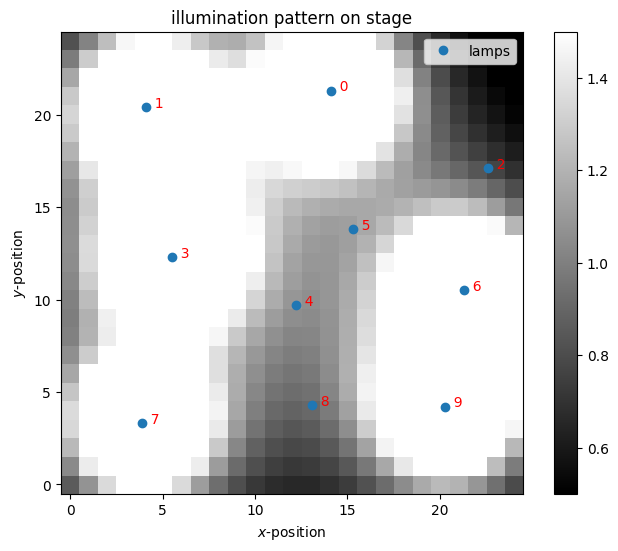

In [381]:
import numpy as np
import matplotlib.pyplot as plt

N = 25
m = N*N
pix_x = np.arange(0,N).reshape(-1,1)@np.ones((1,N))
pix_y = np.ones((N,1))@np.arange(0,N).reshape(1,-1)
pixels = np.hstack(( pix_x.reshape(m,1), pix_y.reshape(m,1), \
                    np.zeros((m,1)) ))

n = 10
lamp_positions = np.array([[14.1, 21.3, 1],  # [x-pos, y_pos, height]
                           [ 4.1, 20.4, 1],  # for 10 lamps
                           [22.6, 17.1, 1],
                           [ 5.5, 12.3, 1],
                           [12.2,  9.7, 1],
                           [15.3, 13.8, 1],
                           [21.3, 10.5, 1],
                           [ 3.9,  3.3, 1],
                           [13.1,  4.3, 1],
                           [20.3,  4.2, 1]])
A = np.zeros((m,n))
for i in range(m):
  for j in range(n):
    A[i,j] = 1.0 / np.linalg.norm(pixels[i,:]-lamp_positions[j,:])**2
A *= m/np.sum(A)


x_ex = np.zeros(n)    # example
x_ex[0] = 4       # lamp-1 on with power=1.5
x_ex[3] = 4        # lamp-5 on with power=3.0
x_ex[1] = 4         # lamp-5 on with power=3.0
x_ex[7] = 4        # lamp-5 on with power=3.0
x_ex[9] = 4     # lamp-5 on with power=3.0
x_ex[6] = 4     # lamp-5 on with power=3.0
y_ex = A.dot(x_ex)    # illumination on stage

plt.figure(figsize=(8,6), dpi=100)
plt.imshow(y_ex.reshape(N,N).T, cmap='gray', origin='lower')
plt.plot(lamp_positions[:,0], lamp_positions[:,1], 'o', label='lamps')
for i in range(n):
  plt.text(lamp_positions[i,0],lamp_positions[i,1], f"  {i}", color="r" )
plt.colorbar()
plt.clim(0.5,1.5)
plt.xlabel(r'$x$-position')
plt.ylabel(r'$y$-position')
plt.title('illumination pattern on stage')
plt.legend()
plt.show()

그러면 램프 2개가 켜진 것이다.

이때 위의 행렬을 통해, 다시 램프의 위치와 켜진 개수 그리고 세기를 동시에 복원하는 문제를 고려해보자.

램프가 켜졌을 때 얻어진 이미지 $y_{measured}$가 있다고 하자.

이때 이는 벡터값이다.

(N\*N)  (N\*N) 정방 행렬 D가 있다고 하자.


이때 D는 각 위치(i,j)에서 램프가 켜졌을 때, 그 위치에 얼마나 영향을 미치는지에 대한 값이다.

또한 x는 (N\*N) 벡터이다.

그러면 아래와 같이 문제를 재구성 할 수 있다.

In [382]:
y_measured = y_ex
print(y_measured.shape)

(625,)


In [383]:
D = np.zeros((N*N,N*N))
for i in range(N):
  for j in range(N):
    for c in range(N):
      for h in range(N):
        window =  25*i+j
        distance =np.sqrt( (i-c)**2 + (j-h)**2 + 1)
        D[25*i+j,25*c+h] = 1/distance
print(D)

[[1.         0.70710678 0.4472136  ... 0.03070028 0.03006924 0.02945   ]
 [0.70710678 1.         0.70710678 ... 0.03134196 0.03070028 0.03006924]
 [0.4472136  0.70710678 1.         ... 0.03199283 0.03134196 0.03070028]
 ...
 [0.03070028 0.03134196 0.03199283 ... 1.         0.70710678 0.4472136 ]
 [0.03006924 0.03070028 0.03134196 ... 0.70710678 1.         0.70710678]
 [0.02945    0.03006924 0.03070028 ... 0.4472136  0.70710678 1.        ]]


                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 07 05:32:39 PM: Your problem has 1250 variables, 1251 constraints, and 0 parameters.
(CVXPY) May 07 05:32:39 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 07 05:32:39 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 07 05:32:39 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 07 05:32:39 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 07 05:32:39 PM: Compiling problem (target solver=CLARAB

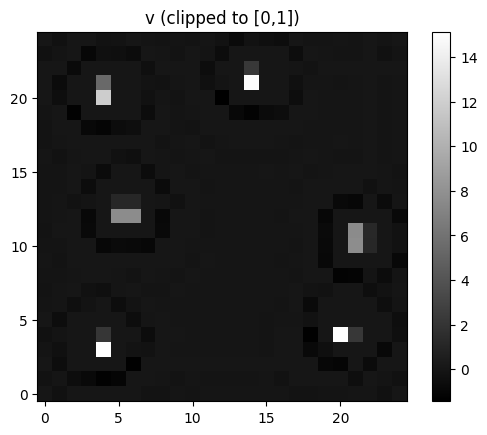

In [384]:
import cvxpy as cp

# 1) 변수 정의: 0 ≤ v ≤ 1
v = cp.Variable(N**2)

# 2) 목적함수는 그대로
lam = 0.1*0.5
obj = cp.Minimize( 0.5* cp.norm( D@v -y_measured, 2 ) +lam *cp.norm(v,1))

# 3) 문제 정의 & 풀이
prob = cp.Problem(obj, constraints)
prob.solve(verbose=True)

# 4) 결과
x_u = v.value.reshape(N, N)
plt.imshow(x_u.T, cmap='gray', origin='lower')
plt.title('v (clipped to [0,1])')
plt.colorbar()
plt.show()



[[-4.17564085e-07 -2.64055966e-01 -1.37540634e-07 -9.70169791e-02
  -2.94500203e-01 -6.60765589e-07 -1.04715737e-01 -1.63643217e-01
  -8.81998153e-02 -7.16737055e-02 -1.14760661e-01 -1.67095221e-01
  -1.40678238e-01 -1.30725073e-01 -1.25676803e-01 -1.11594188e-01
  -5.60346398e-02 -1.88322536e-01 -1.79659011e-01 -8.97230099e-02
  -7.38905199e-07 -4.38450914e-07 -1.14567284e-03 -3.16703644e-01
  -1.03461489e-07]
 [-2.88916256e-01 -2.20478896e-02 -5.79437842e-01 -4.00339424e-01
  -1.29396302e-01 -5.64006423e-01 -2.48580830e-02 -3.84794858e-02
  -1.33773997e-01 -1.74754151e-01 -1.02925633e-01 -1.12568672e-04
  -5.65716383e-02 -3.09554723e-02 -8.45813260e-02 -1.03394176e-01
  -2.28313467e-01 -3.34182933e-02 -8.71014398e-08 -6.89650234e-08
  -5.09812019e-01 -7.12333815e-01 -3.46750843e-07 -1.40064892e-01
  -3.20052951e-01]
 [-9.49744531e-08 -5.64597152e-01 -2.94400970e-08 -3.46590347e-09
  -3.14457162e-09 -1.36425890e-08 -4.62850940e-01 -2.20828783e-07
  -5.32565192e-02 -8.75841786e-03 -6.3

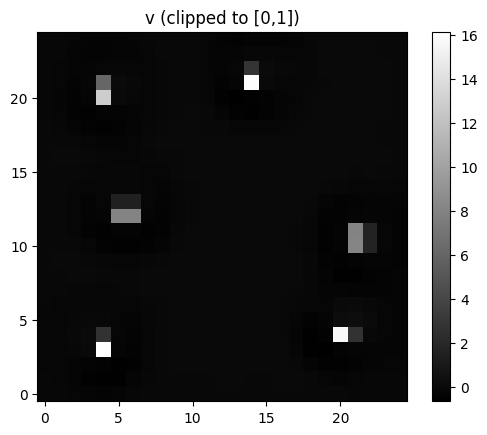

In [385]:



W = np.eye(len(y_measured))
A = D.copy()
F = np.eye(len(y_measured))
rho = 0.1



x_k = np.zeros(len(y_measured))
z_k = np.zeros_like(x_k)
u_k = np.zeros_like(x_k)

def soft_thresholding(x, kappa):
    return np.sign(x) * np.maximum(np.abs(x) - kappa, 0.0)

lhs_matrix = A.T @ W.T @ W @ A + rho * F.T @ F


for k in range(10):

    rhs = A.T @ W.T @ W @ y_measured + rho * F.T @ (z_k - u_k)
    x_next = np.linalg.solve(lhs_matrix, rhs)

    # z-update
    Fx_nu = F @ x_next + u_k
    z_next = soft_thresholding(Fx_nu, 1 / rho)

    # dual-update
    u_next = u_k + F @ x_next - z_next

    # next step
    x_k, z_k, u_k = x_next, z_next, u_next


print(x_u)
x_next = x_next.reshape(N, N)
plt.imshow(x_next.reshape(N, N).T, cmap='gray', origin='lower')
plt.title('v (clipped to [0,1])')
plt.colorbar()
plt.show()


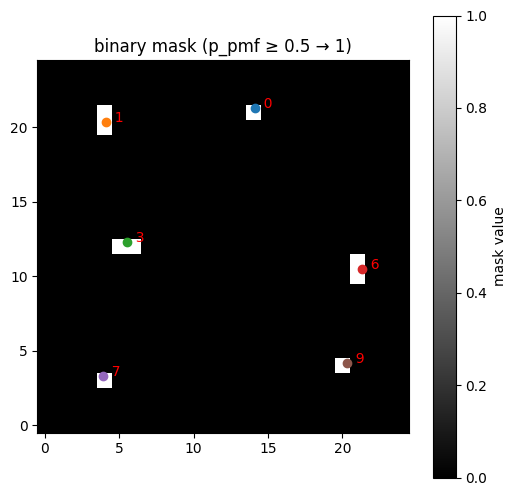

총 9개 픽셀이 1로 설정됨
좌표 목록 (y, x):
(4, 3)
(4, 20)
(4, 21)
(5, 12)
(6, 12)
(14, 21)
(20, 4)
(21, 10)
(21, 11)
[14.1 21.3  1. ]
[ 4.1 20.4  1. ]
[ 5.5 12.3  1. ]
[21.3 10.5  1. ]
[3.9 3.3 1. ]
[20.3  4.2  1. ]


In [386]:

p_pmf = x_u / ((np.max(x_u)+np.min(x_u))/2)
# 0.5 이상인 값만 1, 그 외는 0 으로 변환
mask = (p_pmf >= 0.5).astype(int)

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(mask.T, cmap='gray', origin='lower')

for i in range(n):
  if x_ex[i] != 0:
    plt.plot(lamp_positions[i,0], lamp_positions[i,1], 'o', label='lamps')

for i in range(n):
  if x_ex[i] != 0:
    plt.text(lamp_positions[i,0],lamp_positions[i,1], f"  {i}", color="r" )
plt.title('binary mask (p_pmf ≥ 0.5 → 1)')
plt.colorbar(label='mask value')
plt.show()

# 켜진(1) 픽셀 인덱스 얻기
idx_flat = np.flatnonzero(mask.ravel())
ys, xs = np.where(mask)   # (행, 열) 좌표
print(f"총 {len(idx_flat)}개 픽셀이 1로 설정됨")
print("좌표 목록 (y, x):")
for y, x in zip(ys, xs):
    print(f"({y}, {x})")

for i in range(len(x_ex)):
  if x_ex[i] != 0.0:
    print(lamp_positions[i])

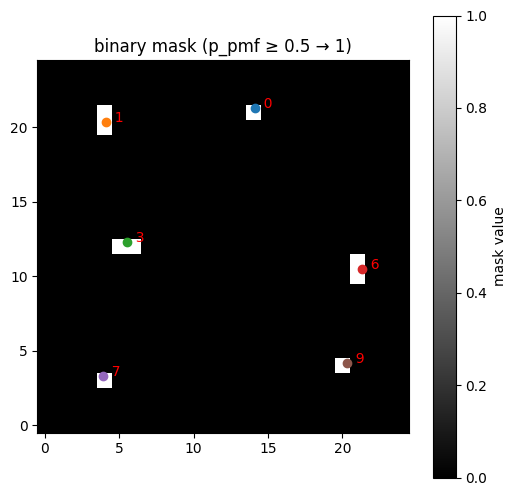

총 9개 픽셀이 1로 설정됨
좌표 목록 (y, x):
(4, 3)
(4, 20)
(4, 21)
(5, 12)
(6, 12)
(14, 21)
(20, 4)
(21, 10)
(21, 11)
[14.1 21.3  1. ]
[ 4.1 20.4  1. ]
[ 5.5 12.3  1. ]
[21.3 10.5  1. ]
[3.9 3.3 1. ]
[20.3  4.2  1. ]


In [387]:

p_pmf = x_next / ((np.max(x_next)+np.min(x_next))/2)
# 0.5 이상인 값만 1, 그 외는 0 으로 변환
mask = (p_pmf >= 0.5).astype(int)

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(mask.T, cmap='gray', origin='lower')

for i in range(n):
  if x_ex[i] != 0:
    plt.plot(lamp_positions[i,0], lamp_positions[i,1], 'o', label='lamps')

for i in range(n):
  if x_ex[i] != 0:
    plt.text(lamp_positions[i,0],lamp_positions[i,1], f"  {i}", color="r" )
plt.title('binary mask (p_pmf ≥ 0.5 → 1)')
plt.colorbar(label='mask value')
plt.show()

# 켜진(1) 픽셀 인덱스 얻기
idx_flat = np.flatnonzero(mask.ravel())
ys, xs = np.where(mask)   # (행, 열) 좌표
print(f"총 {len(idx_flat)}개 픽셀이 1로 설정됨")
print("좌표 목록 (y, x):")
for y, x in zip(ys, xs):
    print(f"({y}, {x})")

for i in range(len(x_ex)):
  if x_ex[i] != 0.0:
    print(lamp_positions[i])

이제 ADMM 접근 방식이 기존 Solver 방식보다 더욱 유효하다는 것을 보였으므로

노이즈가 추가되었다는 것을 가정해보자.

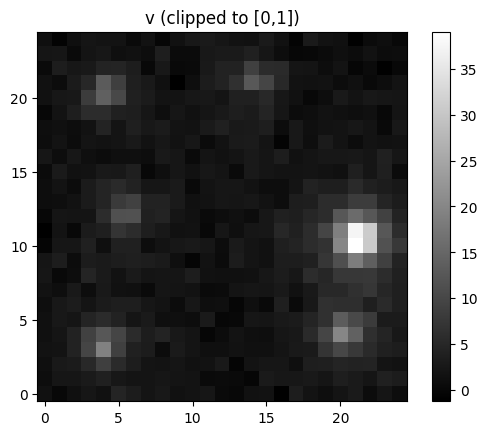

In [388]:
import numpy as np
import matplotlib.pyplot as plt

N = 25
m = N*N
pix_x = np.arange(0,N).reshape(-1,1)@np.ones((1,N))
pix_y = np.ones((N,1))@np.arange(0,N).reshape(1,-1)
pixels = np.hstack(( pix_x.reshape(m,1), pix_y.reshape(m,1), \
                    np.zeros((m,1)) ))

n = 10
lamp_positions = np.array([[14.1, 21.3, 1],  # [x-pos, y_pos, height]
                           [ 4.1, 20.4, 1],  # for 10 lamps
                           [22.6, 17.1, 1],
                           [ 5.5, 12.3, 1],
                           [12.2,  9.7, 1],
                           [15.3, 13.8, 1],
                           [21.3, 10.5, 1],
                           [ 3.9,  3.3, 1],
                           [13.1,  4.3, 1],
                           [20.3,  4.2, 1]])
A = np.zeros((m,n))
for i in range(m):
  for j in range(n):
    A[i,j] = 1.0 / np.linalg.norm(pixels[i,:]-lamp_positions[j,:])**2
A *= m/np.sum(A)


x_ex = np.zeros(n)    # example
x_ex[0] = 3.2     # lamp-1 on with power=1.5
x_ex[3] = 3.4        # lamp-5 on with power=3.0
x_ex[1] = 3.8       # lamp-5 on with power=3.0
x_ex[7] = 4.5       # lamp-5 on with power=3.0
x_ex[9] = 5     # lamp-5 on with power=3.0
x_ex[6] = 12     # lamp-5 on with power=3.0
y_ex = A.dot(x_ex)    # illumination on stage
y_true = y_ex
noise_level = 1
np.random.seed(7030)
y_measured =y_true - noise_level * np.random.randn(*y_true.shape)
plt.imshow(y_measured.reshape(N,N).T, cmap='gray', origin='lower')
plt.title('v (clipped to [0,1])')
plt.colorbar()
plt.show()

In [389]:
np.random.seed(7030)
np.random.randn(*y_true.shape)

array([-5.41845054e-01,  2.62950784e-01,  1.78560836e-01, -1.16994961e-01,
        1.10565226e-01,  5.13406281e-02,  2.36171063e-01, -4.80944057e-01,
       -1.27803800e+00, -1.10632863e+00,  1.41401453e+00,  2.15156517e+00,
        1.06938505e+00,  1.53479308e-01,  2.16793518e-01,  4.52939894e-01,
       -1.18547441e+00,  1.75921293e-01,  1.67161959e-01,  1.29636682e+00,
       -2.90007115e-01, -3.35112392e-01,  6.92482249e-01, -1.16164075e+00,
       -4.04827056e-01,  1.05161962e+00, -6.23565408e-01, -7.51973379e-01,
        5.88857400e-01,  2.31465443e-01, -5.52309099e-01, -9.67293218e-01,
        2.96081156e-01,  9.55754715e-01, -2.17355206e+00, -9.98315761e-01,
       -4.80790550e-01, -8.39531691e-01,  3.33495214e-01, -6.17819907e-01,
       -1.61407843e+00,  4.09834118e-01, -5.03879108e-01,  1.76343873e-01,
       -2.08548658e-02, -5.00611740e-01,  1.10343556e+00, -1.88211158e+00,
       -9.90804813e-01,  1.71524771e+00,  1.57309007e-01, -9.10505105e-02,
        3.69750748e-01,  

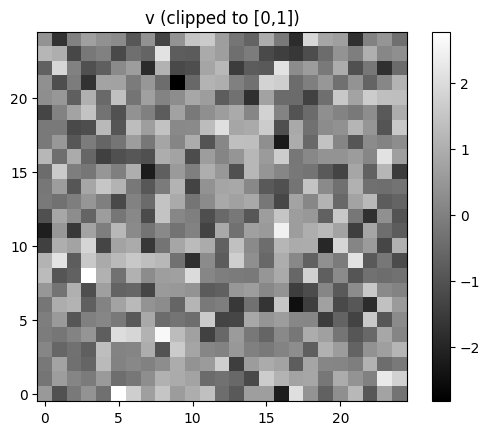

In [390]:
plt.imshow(y_measured.reshape(N,N).T - y_true.reshape(N,N).T, cmap='gray', origin='lower')
plt.title('v (clipped to [0,1])')
plt.colorbar()
plt.show()

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 07 05:32:47 PM: Your problem has 625 variables, 0 constraints, and 0 parameters.
(CVXPY) May 07 05:32:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 07 05:32:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 07 05:32:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 07 05:32:47 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 07 05:32:47 PM: Compiling problem (target solver=CLARABEL).

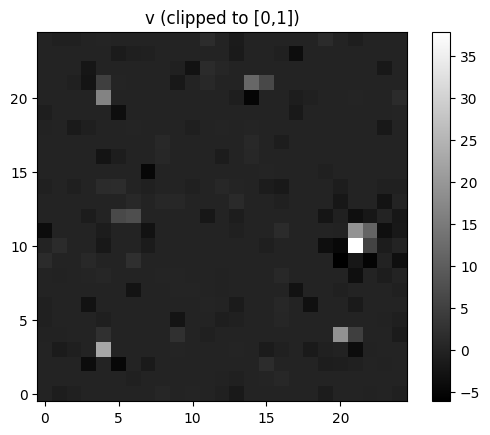

In [391]:
import cvxpy as cp


v = cp.Variable(N**2)

lam = 0.1*0.5
obj = cp.Minimize( 0.5* cp.norm( D@v -y_measured, 2 ) +lam *cp.norm(v,1) + 0.1* cp.norm( D@v -y_measured, 1 ) )

prob = cp.Problem(obj)
prob.solve(verbose=True)

# 4) 결과
x_u = v.value.reshape(N, N)
plt.imshow(x_u.T, cmap='gray', origin='lower')
plt.title('v (clipped to [0,1])')
plt.colorbar()
plt.show()



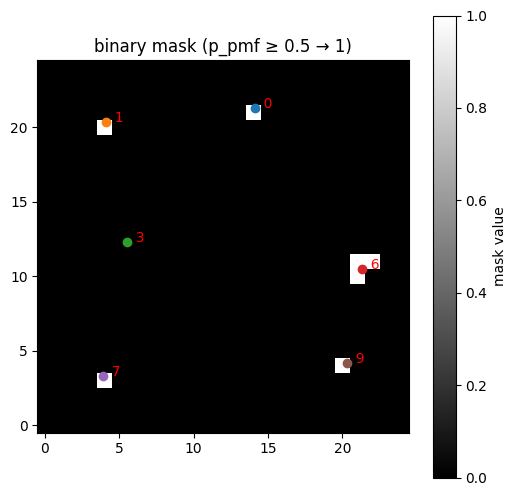

총 7개 픽셀이 1로 설정됨
좌표 목록 (y, x):
(4, 3)
(4, 20)
(14, 21)
(20, 4)
(21, 10)
(21, 11)
(22, 11)
[14.1 21.3  1. ]
[ 4.1 20.4  1. ]
[ 5.5 12.3  1. ]
[21.3 10.5  1. ]
[3.9 3.3 1. ]
[20.3  4.2  1. ]


In [392]:

p_pmf = x_u / ((np.max(x_u)+np.min(x_u))/2)
# 0.5 이상인 값만 1, 그 외는 0 으로 변환
mask = (p_pmf >= 0.5).astype(int)

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(mask.T, cmap='gray', origin='lower')

for i in range(n):
  if x_ex[i] != 0:
    plt.plot(lamp_positions[i,0], lamp_positions[i,1], 'o', label='lamps')

for i in range(n):
  if x_ex[i] != 0:
    plt.text(lamp_positions[i,0],lamp_positions[i,1], f"  {i}", color="r" )
plt.title('binary mask (p_pmf ≥ 0.5 → 1)')
plt.colorbar(label='mask value')
plt.show()

# 켜진(1) 픽셀 인덱스 얻기
idx_flat = np.flatnonzero(mask.ravel())
ys, xs = np.where(mask)   # (행, 열) 좌표
print(f"총 {len(idx_flat)}개 픽셀이 1로 설정됨")
print("좌표 목록 (y, x):")
for y, x in zip(ys, xs):
    print(f"({y}, {x})")

for i in range(len(x_ex)):
  if x_ex[i] != 0.0:
    print(lamp_positions[i])

Starting ADMM solver...
Iter 0: Change_v = 2.65e+13, ||v-z1||=2.32e+00, ||Dv-y-z2||=2.75e+00
Iter 10: Change_v = 1.83e-02, ||v-z1||=1.55e-01, ||Dv-y-z2||=1.37e-01
Iter 20: Change_v = 1.14e-02, ||v-z1||=9.01e-02, ||Dv-y-z2||=1.11e-01
Iter 29: Change_v = 8.94e-03, ||v-z1||=4.46e-02, ||Dv-y-z2||=7.48e-02
실행 시간: 0.073957 초


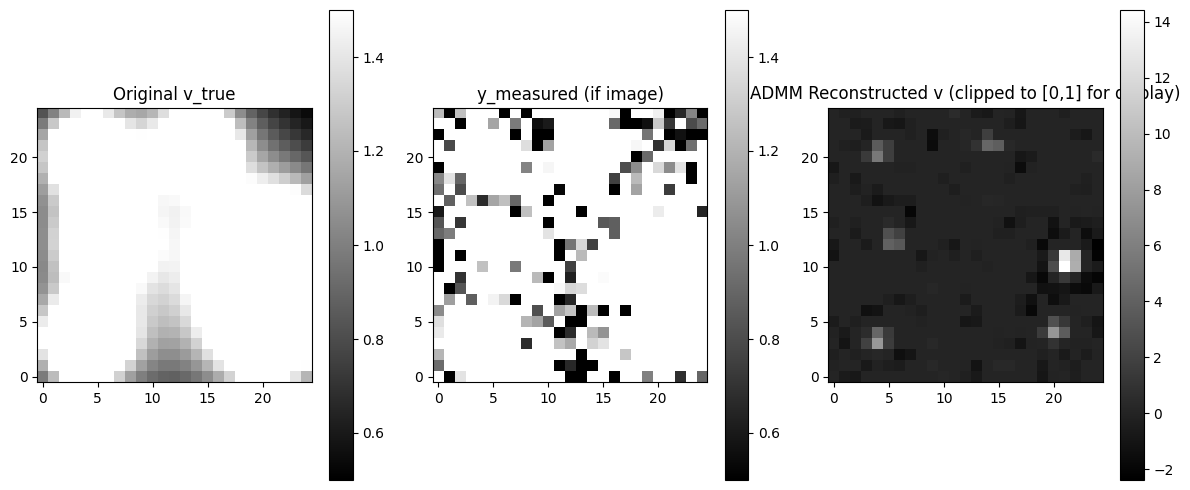

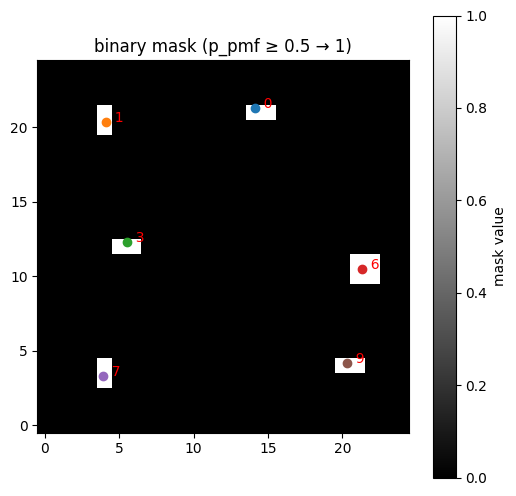

총 14개 픽셀이 1로 설정됨
좌표 목록 (y, x):
(4, 3)
(4, 4)
(4, 20)
(4, 21)
(5, 12)
(6, 12)
(14, 21)
(15, 21)
(20, 4)
(21, 4)
(21, 10)
(21, 11)
(22, 10)
(22, 11)
[14.1 21.3  1. ]
[ 4.1 20.4  1. ]
[ 5.5 12.3  1. ]
[21.3 10.5  1. ]
[3.9 3.3 1. ]
[20.3  4.2  1. ]


In [395]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import time

def soft_threshold(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)


def prox_l1_l2(arg, alpha_l1, beta_l2, epsilon=1e-12):
    s_temp = soft_threshold(arg, alpha_l1)
    norm_s_temp = np.linalg.norm(s_temp)
    if norm_s_temp == 0:
        return s_temp
    else:
        return s_temp * np.maximum(0, 1 - beta_l2 / (norm_s_temp + epsilon))


def admm_solver(D, y_measured, N, lam_param, lambda2_l1_coeff=0.1, lambda2_l2_coeff=0.5,
                rho=1.0, num_iters=100, tol=1e-4, verbose=False):

    n_pixels = N * N
    m_measurements = D.shape[0]
    v = np.zeros(n_pixels)
    z1 = np.zeros(n_pixels)
    z2 = np.zeros(m_measurements)
    u1 = np.zeros(n_pixels)
    u2 = np.zeros(m_measurements)
    Dt = D.T
    DtD = Dt @ D
    I_n_pixels = np.eye(n_pixels)

    try:

        LHS_v_matrix = I_n_pixels + DtD
        cholesky_L, lower_flag = scipy.linalg.cho_factor(LHS_v_matrix, lower=True)
        def solve_v_system(rhs):
            return scipy.linalg.cho_solve((cholesky_L, lower_flag), rhs)
    except scipy.linalg.LinAlgError:
        print("Cholesky decomposition failed. Using np.linalg.solve (slower).")
        LHS_v_matrix_inv = np.linalg.inv(I_n_pixels + DtD)
        def solve_v_system(rhs):
            return LHS_v_matrix_inv @ rhs
    except Exception as e:
        print(f"An unexpected error occurred during Cholesky decomp: {e}")
        print("Using np.linalg.solve (slower).")
        LHS_v_matrix_inv = np.linalg.inv(I_n_pixels + DtD)
        def solve_v_system(rhs):
            return LHS_v_matrix_inv @ rhs



    history_obj = []

    for k in range(num_iters):
        v_old = v.copy()
        rhs_v = z1 - u1/rho + Dt @ (y_measured + z2 - u2/rho)
        v = solve_v_system(rhs_v)
        arg_z1 = v + u1/rho
        z1 = soft_threshold(arg_z1, lam_param/rho)
        arg_z2 = D@v - y_measured + u2/rho
        alpha_prox_z2 = lambda2_l1_coeff / rho
        beta_prox_z2 = lambda2_l2_coeff / rho
        z2 = prox_l1_l2(arg_z2, alpha_prox_z2, beta_prox_z2)
        r_p1 = v - z1
        r_p2 = D@v - y_measured - z2
        u1 = u1 + rho * r_p1
        u2 = u2 + rho * r_p2
        change_v = np.linalg.norm(v - v_old) / (np.linalg.norm(v_old) + 1e-12)
        if verbose and (k % 10 == 0 or k == num_iters - 1):
            primal_res_norm1 = np.linalg.norm(r_p1)
            primal_res_norm2 = np.linalg.norm(r_p2)
            print(f"Iter {k}: Change_v = {change_v:.2e}, ||v-z1||={primal_res_norm1:.2e}, ||Dv-y-z2||={primal_res_norm2:.2e}")


        if change_v < tol and k > 10:
            print(f"Converged at iteration {k}.")
            break

    return v


if __name__ == '__main__':
    N = 25
    n_pixels = N * N
    m_measurements = n_pixels // 2
    lam_param_cvxpy = 0.1
    lambda2_l1_coeff_cvxpy = 0.1
    lambda2_l2_coeff_cvxpy = 0.5
    rho_admm = 1.0
    num_iters_admm = 30

    print("Starting ADMM solver...")
    start = time.perf_counter()
    v_admm = admm_solver(D, y_measured, N,
                         lam_param=lam_param_cvxpy,
                         lambda2_l1_coeff=lambda2_l1_coeff_cvxpy,
                         lambda2_l2_coeff=lambda2_l2_coeff_cvxpy,
                         rho=rho_admm,
                         num_iters=num_iters_admm,
                         verbose=True)
    end = time.perf_counter()

    print(f"실행 시간: {end - start:.6f} 초")

    x_u_admm = v_admm.reshape(N, N)


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(y_true.reshape(N,N).T, cmap='gray', origin='lower', vmin=0, vmax=1)
    plt.title('Original v_true')
    plt.clim(0.5,1.5)
    plt.colorbar()

    plt.subplot(1, 3, 2)

    if D.shape[0] == n_pixels:
         plt.imshow(y_measured.reshape(N,N).T, cmap='gray', origin='lower')
         plt.title('y_measured (if image)')
         plt.clim(0.5,1.5)
         plt.colorbar()
    else:
        plt.plot(y_measured)
        plt.title('y_measured (vector)')


    plt.subplot(1, 3, 3)
    plt.imshow(x_u_admm.T, cmap='gray', origin='lower')
    plt.title('ADMM Reconstructed v (clipped to [0,1] for display)')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    p_pmf = x_u_admm / ((np.max(x_u_admm)+np.min(x_u_admm))/2)

    mask = (p_pmf >= 0.5).astype(int)

    # 시각화
    plt.figure(figsize=(6,6))
    plt.imshow(mask.T, cmap='gray', origin='lower')

    for i in range(n):
      if x_ex[i] != 0:
        plt.plot(lamp_positions[i,0], lamp_positions[i,1], 'o', label='lamps')

    for i in range(n):
      if x_ex[i] != 0:
        plt.text(lamp_positions[i,0],lamp_positions[i,1], f"  {i}", color="r" )
    plt.title('binary mask (p_pmf ≥ 0.5 → 1)')
    plt.colorbar(label='mask value')
    plt.show()

    # 켜진(1) 픽셀 인덱스 얻기
    idx_flat = np.flatnonzero(mask.ravel())
    ys, xs = np.where(mask)   # (행, 열) 좌표
    print(f"총 {len(idx_flat)}개 픽셀이 1로 설정됨")
    print("좌표 목록 (y, x):")
    for y, x in zip(ys, xs):
        print(f"({y}, {x})")

    for i in range(len(x_ex)):
      if x_ex[i] != 0.0:
        print(lamp_positions[i])